In [12]:
# %load ~/scripts/j.py
# A set of jupyter notebook presets. Located in ~/scripts/jpy.py

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import tqdm

colors_k = [[0.8872, 0.4281, 0.1875],
            [0.2634, 0.6634, 0.4134],
            [0.0943, 0.5937, 0.8793],
            [0.3936, 0.2946, 0.6330]]


params = {'legend.fontsize': 22,
          'axes.labelsize': 30,
          'axes.titlesize': 30,
          'xtick.labelsize': 27,
          'ytick.labelsize': 22}
pylab.rcParams.update(params)

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'serif'
matplotlib.rcParams['text.usetex'] = False
plt.rcParams["font.family"] = "cmr10"

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
N_fams = 3
linewidth = 4
legend_offset = -.27


In [13]:
import os
import torch
import numpy as np
import glob
import re
import pandas as pd
import sys
from data.generate_data import *
import matplotlib.pyplot as plt
import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from learned_inv.aug import *
softplus = torch.nn.Softplus()
xent = torch.nn.CrossEntropyLoss(reduction='none')
rots = range(-180, 180, 5)

import torch.nn.functional as F
from imageio import imsave

softplus = torch.nn.Softplus()
savedir = "./saved-outputs/"

ntrain = 10000
ntest = 5000

trainloader, testloader = generate_mario_data(ntrain=ntrain, ntest=ntest,
                                              batch_size=128, dpath="./data/")
it = iter(trainloader)

ntrain_each: 5000 train_mario_angles: torch.Size([5000])
ntest_each: 2500 test_mario_angles: torch.Size([2500])


/home/utkarsh/anaconda3/envs/pt111/lib/python3.9/site-packages/torch/nn/functional.py:4255: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/utkarsh/anaconda3/envs/pt111/lib/python3.9/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [14]:
def get_rot_mat(theta):
    return torch.stack([torch.stack([torch.cos(theta), -torch.sin(theta), theta*0]),
                        torch.stack([torch.sin(theta), torch.cos(theta), theta*0])], axis=0)


grid_sample = torch.nn.functional.grid_sample

def rot_img(x, theta):
    if type(theta) in [float, int]:
        theta = torch.tensor(theta).to(x.device)
    theta = theta*np.pi/180.0
    rot_mat = get_rot_mat(theta)[None, ...].repeat(x.shape[0], 1, 1)
    grid = F.affine_grid(rot_mat, x.size())
    x = grid_sample(x, grid)
    return x


xent = torch.nn.CrossEntropyLoss(reduction='none')

rots = range(-180, 180, 5)

In [15]:
xent = torch.nn.CrossEntropyLoss(reduction='none')

rots = range(-180, 180, 5)


def align(model, X, iters=15, n_samps=100, alpha=0.1, use_tqdm=True, init_weights=None, return_aug=False):
    N, C, H, W = X.shape
    total_weights = torch.zeros(N, 6).cuda().float()
    
    if init_weights is not None:
        total_weights = init_weights
        
    inp = X*1.0
    inp_list = [inp.clone().detach().cpu().numpy()]
    weights_list = [] #!
    total_weights_list = []

    iterator = tqdm.trange(iters) if use_tqdm else range(iters)
    with torch.no_grad():
        for _ in iterator:
            emb = model.pose_embedder(inp)
            weights, logp = model.augmenter.sample_weights(emb.repeat(n_samps, 1))

            weights = model.augmenter.format_weights(weights)

            weights = weights.reshape(n_samps, emb.shape[0], -1)
            weights_samp = weights.clone().detach()

            weights = weights_samp.mean(dim=0).detach()
            
            total_weights = total_weights + weights*alpha

            affines = model.augmenter.weights_to_affine(total_weights)
            out = model.augmenter.apply_affine(X, affines)
            
            inp = out
            inp_list.append(inp.clone().detach().cpu().numpy())
            total_weights_list.append(total_weights.detach().cpu().numpy())
            weights_list.append(weights_samp.detach().cpu().numpy())
        
        if return_aug:
            weights_aug = total_weights + weights_samp
            weights_aug = weights_aug.reshape(N*n_samps, 6)
            affines = model.augmenter.weights_to_affine(weights_aug)
            augmented = model.augmenter.apply_affine(X[None,...].repeat(n_samps, 1, 1, 1, 1).reshape(N*n_samps, C, H, W), affines).reshape(n_samps, N, C, H, W)
            return inp_list, augmented
        return inp_list, weights_list, total_weights_list 

### Apply this to MNIST

In [16]:
model = torch.load('ckpt/mario_rot_45/new_model.pt')

In [17]:
mnist_test = MNIST("./data/mnist/", train=False, download=True, transform=transforms.ToTensor())

## Debugging current code

/tmp/ipykernel_21828/1756723398.py:12: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.subplot(2,10,i)


tensor(0.1141, device='cuda:0')


  3%|▎         | 2/60 [00:00<00:05, 10.77it/s]

100%|██████████| 60/60 [00:05<00:00, 10.58it/s]
/tmp/ipykernel_21828/1756723398.py:19: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.subplot(2,10,i+9)


0.101274975


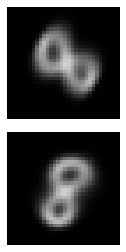

In [18]:
iters = 60
model.augmenter.padding_mode = 'zeros'
i = 1
all_inp_lists = {}
plt.figure(figsize=(20, 4))
for label in [8]:
    imgs = torch.cat([mnist_test[i][0][None,...] for i in range(len(mnist_test)) if mnist_test[i][1] == label]).cuda()
    imgs = F.pad(imgs, (2, 2, 2, 2), mode='constant', value=0).repeat(1,3,1,1).cuda()

    imgs = torch.cat([rot_img(inp_[None,...], 60) for inp_ in imgs], dim=0) # TUrn all by 60

    plt.subplot(2,10,i)
    plt.imshow(imgs.mean(0).detach().cpu().numpy().transpose(1, 2, 0))

    i += 1
    plt.axis('off')
    print(imgs.std(0).mean())
    inp_list, weights_list, total_weights_list =  align(model, imgs, iters=iters, n_samps=500, alpha=0.1)  
    plt.subplot(2,10,i+9)
    plt.imshow(inp_list[-1].mean(0).transpose(1, 2, 0))
    all_inp_lists[label] = inp_list
    plt.tight_layout()
    plt.axis('off')
    print(inp_list[-1].std(0).mean())

/tmp/ipykernel_21828/2138309324.py:4: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.subplot(1,5,1)
/tmp/ipykernel_21828/2138309324.py:9: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.subplot(1,5,2)
/tmp/ipykernel_21828/2138309324.py:14: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.subplot(1,5,3)
/tmp/ipykernel_21828/2138309324.py:19: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.subplot(1,5,4)
/tmp/ipykernel_21828/2138309324.py:23: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.subplot(1,5,5)


(-0.5, 31.5, 31.5, -0.5)

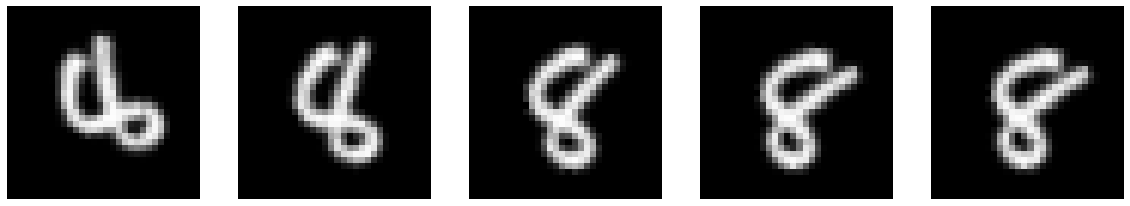

In [19]:
idx = 5

plt.figure(figsize=(20, 4))
plt.subplot(1,5,1)
plt.imshow(all_inp_lists[8][1][idx].transpose(1, 2, 0))
plt.axis('off')


plt.subplot(1,5,2)
plt.imshow(all_inp_lists[8][10][idx].transpose(1, 2, 0))
plt.axis('off')


plt.subplot(1,5,3)
plt.imshow(all_inp_lists[8][20][idx].transpose(1, 2, 0))
plt.axis('off')


plt.subplot(1,5,4)
plt.imshow(all_inp_lists[8][50][idx].transpose(1, 2, 0))
plt.axis('off')

plt.subplot(1,5,5)
plt.imshow(all_inp_lists[8][-1][idx].transpose(1, 2, 0))
plt.axis('off')

/tmp/ipykernel_21828/3682643135.py:17: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(np.linspace(-np.pi, np.pi, 20)[:-1], hist1, alpha=1, color=cmap(i/max_i), linewidth=2.5)
/tmp/ipykernel_21828/3682643135.py:37: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cb =plt.colorbar(sm, label='Iterations')


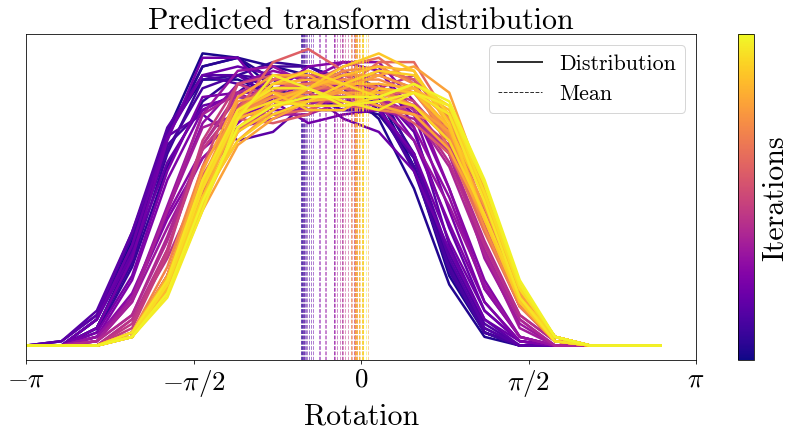

In [20]:
from scipy.signal import savgol_filter
# import gaussian fitler
from scipy.ndimage import gaussian_filter1d
plt.figure(figsize=(15, 6))


cmap = plt.cm.plasma

max_i = iters
for i in range(max_i):
    hist1 = np.histogram(weights_list[i][:, idx, 2],  bins=np.linspace(-np.pi, np.pi, 20))[0]
    # Smooth with gaussian filter
    hist1 = gaussian_filter1d(hist1, 1)
    # Darken with i to see the evolution, change line color in plt.plot
    # plt.plot(np.linspace(-np.pi, np.pi, 20)[:-1], hist1, alpha=0.4, color=[i/max_i, 0/max_i, 0/max_i], linewidth=2) 
    # Replicate the line above, but with a plasma colormap instead of a single color
    plt.plot(np.linspace(-np.pi, np.pi, 20)[:-1], hist1, alpha=1, color=cmap(i/max_i), linewidth=2.5) 
    
    # Plot vertical dotted line at the mean
    plt.axvline(weights_list[i][:, idx, 2].mean(),  alpha=0.5, linestyle='--', color=cmap(i/max_i), linewidth=1) 

plt.xlim(-np.pi, np.pi)
# plt.legend()
plt.yticks([])
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
plt.xlabel("Rotation")
plt.title('Predicted transform distribution')

# Legend denoting solid line as distribution and dashed line as mean
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color='black', alpha=0.8, linewidth=2, label='Distribution')
blue_dashed_line = mlines.Line2D([], [], color='black', alpha=0.8, linestyle='--', linewidth=1, label='Mean')
# Addition to legend for colormap, and mark it as iterations
import matplotlib.cm as cm
sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_i))
sm._A = []
cb =plt.colorbar(sm, label='Iterations')
# Remove ticks and labels on colorbar
cb.ax.tick_params(length=0)
cb.ax.set_yticklabels([])
plt.legend(handles=[blue_line, blue_dashed_line], loc='upper right')

/tmp/ipykernel_21828/1229887029.py:17: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(np.linspace(-np.pi, np.pi, 20)[:-1], hist1, alpha=1, color=cmap(i/max_i), linewidth=2.5)
/tmp/ipykernel_21828/1229887029.py:37: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cb =plt.colorbar(sm, label='Iterations')


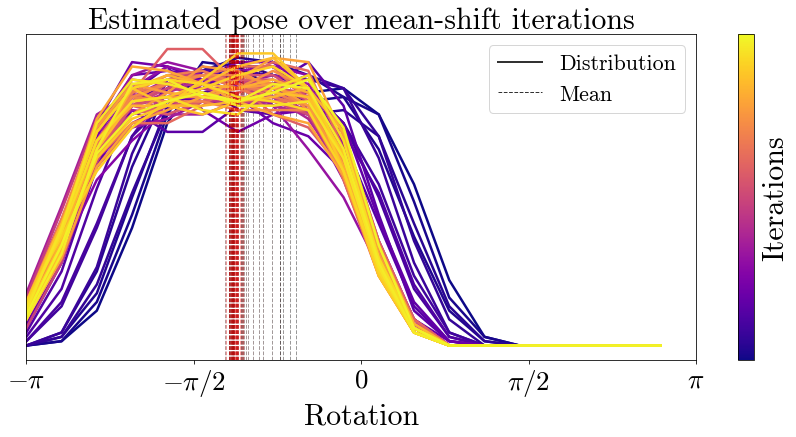

In [21]:
from scipy.signal import savgol_filter
# import gaussian fitler
from scipy.ndimage import gaussian_filter1d
plt.figure(figsize=(15, 6))


cmap = plt.cm.plasma


max_i = iters
for i in range(max_i):
    hist1 = np.histogram(weights_list[i][:, idx, 2]+total_weights_list[i][idx, 2],  bins=np.linspace(-np.pi, np.pi, 20))[0]
    hist1 = gaussian_filter1d(hist1, 1)
    # Darken with i to see the evolution, change line color in plt.plot
    # plt.plot(np.linspace(-np.pi, np.pi, 20)[:-1], hist1, alpha=0.4, color=[i/max_i, 0/max_i, 0/max_i], linewidth=2) 
    # Replicate the line above, but with a plasma colormap instead of a single color
    plt.plot(np.linspace(-np.pi, np.pi, 20)[:-1], hist1, alpha=1, color=cmap(i/max_i), linewidth=2.5) 
    
    # Plot vertical dotted line at the mean
    plt.axvline(weights_list[i][:, idx, 2].mean()+total_weights_list[i][idx, 2].mean(),  alpha=0.4,linestyle='--', color=[i/max_i, 0/max_i, 0/max_i], linewidth=1) 


plt.xlim(-np.pi, np.pi)
plt.yticks([])
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
plt.xlabel("Rotation")
plt.title('Estimated pose over mean-shift iterations')

# Legend denoting solid line as distribution and dashed line as mean
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color='black', alpha=0.8, linewidth=2, label='Distribution')
blue_dashed_line = mlines.Line2D([], [], color='black', alpha=0.8, linestyle='--', linewidth=1, label='Mean')
# Addition to legend for colormap, and mark it as iterations
import matplotlib.cm as cm
sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_i))
sm._A = []
cb =plt.colorbar(sm, label='Iterations')
# Remove ticks and labels on colorbar
cb.ax.tick_params(length=0)
cb.ax.set_yticklabels([])
plt.legend(handles=[blue_line, blue_dashed_line], loc='upper right')

# plt.savefig('sep12_mnist_congeal_cumulative_pose_dist.pdf', bbox_inches='tight', pad_inches=0)

/tmp/ipykernel_21828/1061941878.py:11: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(total_weights_curve, linewidth=3, color='red', label='Estimated pose')


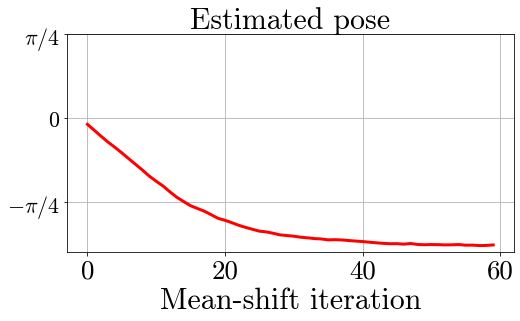

In [22]:
from scipy.signal import savgol_filter
# import gaussian fitler
from scipy.ndimage import gaussian_filter1d
plt.figure(figsize=(8, 4))

max_i = iters
total_weights_curve = []
for i in range(max_i):
    total_weights_curve.append(total_weights_list[i][idx, 2].mean())

plt.plot(total_weights_curve, linewidth=3, color='red', label='Estimated pose')
plt.yticks([-np.pi/4, 0,np.pi/4], [r'$-\pi/4$', r'$0$', r'$\pi/4$'])
plt.xlabel("Mean-shift iteration")
plt.title('Estimated pose')
plt.grid(which='both')

# plt.savefig('sep12_mnist_congeal_est_pose.pdf', bbox_inches='tight', pad_inches=0)